## Quantum Support Vector Machine for Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC

# Set seed for random generators
algorithm_globals.random_seed = 1234

In [2]:
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024,
                                   seed_simulator=1234, seed_transpiler=1234)

In [3]:
# Generate data
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

In [4]:
# Helper function for plotting data
def plot_adhoc_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):
    plt.figure(figsize=(8, 8))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
               origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

    plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1],
                marker='s', facecolors='w', edgecolors='b', label="A train")
    plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
                marker='o', facecolors='w', edgecolors='r', label="B train")
    plt.scatter(test_features[np.where(test_labels[:] == 0), 0], test_features[np.where(test_labels[:] == 0), 1],
                marker='s', facecolors='b', edgecolors='w', label="A test")
    plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
                marker='o', facecolors='r', edgecolors='w', label="B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Ad hoc dataset for classification")

    plt.show()

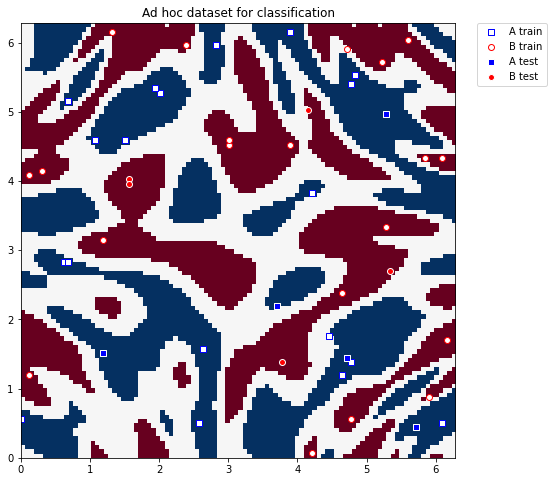

In [5]:
plot_adhoc_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

In [6]:
# Build a classical kernel
svc = SVC(kernel='rbf') # radial basis function kernel; kernel choices: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
svc.fit(train_features, train_labels)
print("Classical SVC score: ", svc.score(test_features, test_labels))

Classical SVC score:  0.4


In [7]:
# Build a quantum kernel
z_feature_map = ZFeatureMap(feature_dimension=adhoc_dimension, reps=2)
zz_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension, reps=2, entanglement='full')
z_kernel = QuantumKernel(feature_map=z_feature_map, quantum_instance=qi)
zz_kernel = QuantumKernel(feature_map=zz_feature_map, quantum_instance=qi)

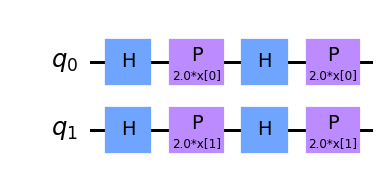

In [8]:
z_feature_map.decompose().draw(output='mpl', scale=1.5) # P gate = phase gate, i.e. Rz gate

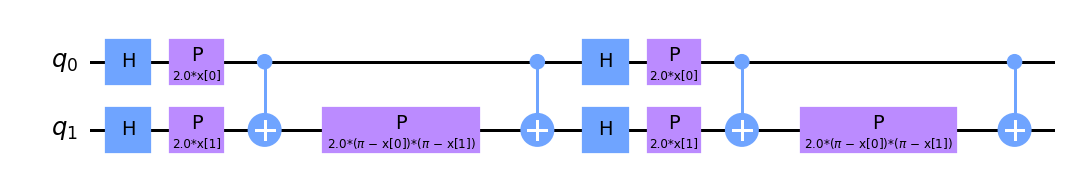

In [9]:
zz_feature_map.decompose().draw(output="mpl", scale=1.5)

In [10]:
qsvc_z = QSVC(quantum_kernel=z_kernel)
qsvc_z.fit(train_features, train_labels)
print("Quantum SVC with Z Feature Map score: ", qsvc_z.score(test_features, test_labels))

Quantum SVC with Z Feature Map score:  0.7


In [11]:
qsvc_zz = QSVC(quantum_kernel=zz_kernel)
qsvc_zz.fit(train_features, train_labels)
print("Quantum SVC with ZZ Feature Map score: ", qsvc_zz.score(test_features, test_labels))

Quantum SVC with ZZ Feature Map score:  1.0


In [12]:
qsvc_zz.predict(test_features)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Hybrid QNNs with TorchConnector for MNIST Classification

In [13]:
# Additional imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

from qiskit.opflow import AerPauliExpectation
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

In [14]:
# declare quantum instance
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

### 1. Data loading (train & test)

In [15]:
# Train Dataset

# Set train shuffle seed (for reproducibility)
torch.manual_seed(1234)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

In [16]:
# Get dimension of train data
X_train.data.shape

torch.Size([200, 28, 28])

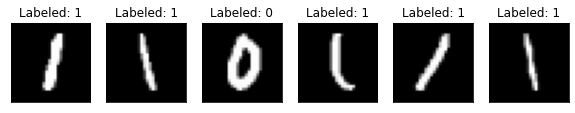

In [17]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [18]:
# Test Dataset
n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### 2. Defining the QNN and hybrid model

After defining our quantum neural network layer (in this case, a `TwoLayerQNN`), we can embed it into a layer in our torch `Module` by initializing a torch connector as `TorchConnector(qnn)`.

In [19]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=2)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        2,
        feature_map,
        ansatz,
        input_gradients=True,
        exp_val=AerPauliExpectation(),
        quantum_instance=qi,
    )
    return qnn


qnn = create_qnn()
print(qnn.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌────────────────────────────────────────────────┐
  «q_0: ┤0                                               ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) │
  «q_1: ┤1                                               ├
  «     └────────────────────────────────────────────────┘
  )
])


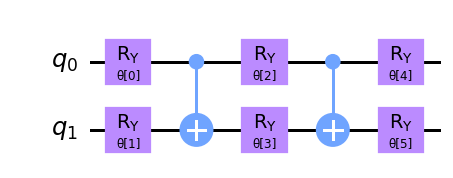

In [20]:
RealAmplitudes(2, reps=2).decompose().draw(output="mpl", scale=1.5)

In [21]:
# Define torch NN module
class Net(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen uniformly at random from interval [-1, 1].
        self.fc3 = nn.Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN, outputs the Pauli-Z expectation values of n qubits
        # x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [22]:
hb_model = Net(qnn)
print(hb_model(X_train.data[10].unsqueeze(0).unsqueeze(0).float()))
print(X_train.targets[10])

tensor([[-0.4194,  1.4194]], grad_fn=<CatBackward0>)
tensor(0)


### 3. Training the hybrid model

We will be using the `Adam` optimizer from `torch.optim` and the `NLLLoss` from `torch.nn`. The negative log likelihood loss is commonly used for classification, where the input can be thought of as the log-probabilities of each class. So the input dimension should be (batch_size, num_classes).

In [23]:
# Define model, optimizer, and loss function
hb_model = Net(qnn)
optimizer = optim.Adam(hb_model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()  # Negative log likelihood loss

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
hb_model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = hb_model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -0.8812
Training [20%]	Loss: -1.0658
Training [30%]	Loss: -1.2401
Training [40%]	Loss: -1.3481
Training [50%]	Loss: -1.3782
Training [60%]	Loss: -1.4079
Training [70%]	Loss: -1.4207
Training [80%]	Loss: -1.4299
Training [90%]	Loss: -1.4375
Training [100%]	Loss: -1.4658


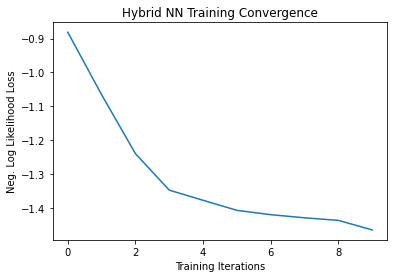

In [24]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [25]:
torch.save(hb_model.state_dict(), "hb_model.pt")

### 4. Testing the trained model

In [26]:
qnn_new = create_qnn()
hb_model_trained = Net(qnn_new)
hb_model_trained.load_state_dict(torch.load("hb_model.pt"))

<All keys matched successfully>

In [27]:
loss_func = nn.NLLLoss()
total_loss = []
hb_model_trained.eval()  # set model to evaluation mode

with torch.no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = hb_model_trained(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # torch.eq computes element-wise equality

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -1.4842
	Accuracy: 100.0%


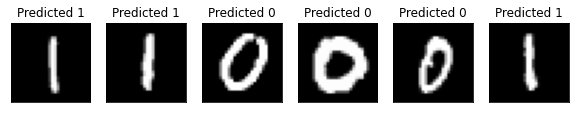

In [28]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

hb_model_trained.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = hb_model_trained(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1